# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 01: Feature Backfill</span>

The project uses [Hopsworks](https://www.hopsworks.ai) as the platform to store features in the **Hopworks Feature Store** and save the trained models in **Hopworks Model Registry**.

## <span style='color:#2656a3'> 🗒️ The notebook is divided into the following sections:
1. Loading the data and process features.
2. Exploratory Data Analysis
3. Connecting to Hopsworks Feature Store.
4. Creating feature groups and uploading them to the feature store.

## <span style='color:#2656a3'> ⚙️ Import of Libraries and Packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for electricity prices, weather measures, and the Danish calendar. Then, we proceed to import some of the necessary libraries and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for electricity prices, weather measures, and the danish calendar
from features import electricity_prices, weather_measures, calendar

# We go back into the notebooks folder
%cd pipeline

/Users/camillahannesbo/Documents/AAU/Master - BDS/2. semester/2. semester project/bds_m7_second-semester-project
/Users/camillahannesbo/Documents/AAU/Master - BDS/2. semester/2. semester project/bds_m7_second-semester-project/pipeline


In [2]:
# Importing pandas for data handling
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 💽 Loading the Historical Data

The data used comes from the following different sources:

- Hourly electricity prices in Denmark per day on price area DK1 from [Energinet](https://www.energidataservice.dk).  Located in the folder folder `features/electricity_prices`.
- Different meteorological observations based on Aalborg Denmark from [Open Meteo](https://www.open-meteo.com). Located in the folder `features/weather_measures`.
- Weather Forecast based on Aalborg Denmark from [Open Meteo](https://www.open-meteo.com). Located in the folder `features/weather_measures`. (This data is used later to parse new real-time weather data)
- Danish calendar that categorizes dates into types based on whether it is a workday or not. The Calendar is imported from the Python Danish holiday library. Located in the folder `features/calendar`.


### <span style="color:#2656a3;">💸 Electricity Prices per day from Energinet
The first dataset we load is hourly electricity prices per day from Energinet/Dataservice.

In [3]:
# Fetching historical electricity prices for area DK1 from January 1, 2022
# Note: The end date is currently left out to retrieve data up to the day before present date 
# Today is not included in the data as it is not historical data
electricity_df = electricity_prices.electricity_prices(
    historical=True, 
    area=["DK1"], 
    start='2022-01-01'
)

In [4]:
# Display the first 5 rows of the electricity dataframe
electricity_df.head(5)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh
0,1640995200000,2022-01-01 00:00:00,2022-01-01,0,0.37220
1,1640998800000,2022-01-01 01:00:00,2022-01-01,1,0.30735
2,1641002400000,2022-01-01 02:00:00,2022-01-01,2,0.32141
3,1641006000000,2022-01-01 03:00:00,2022-01-01,3,0.33806
4,1641009600000,2022-01-01 04:00:00,2022-01-01,4,0.28013


In [5]:
# Display the last 5 rows of the electricity dataframe
electricity_df.tail(5)

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh
20944,1716404400000,2024-05-22 19:00:00,2024-05-22,19,0.74541
20945,1716408000000,2024-05-22 20:00:00,2024-05-22,20,1.01865
20946,1716411600000,2024-05-22 21:00:00,2024-05-22,21,0.87554
20947,1716415200000,2024-05-22 22:00:00,2024-05-22,22,0.74384
20948,1716418800000,2024-05-22 23:00:00,2024-05-22,23,0.65468


In [6]:
# Show the information for the electricity dataframe
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20949 entries, 0 to 20948
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             20949 non-null  int64         
 1   datetime              20949 non-null  datetime64[ns]
 2   date                  20949 non-null  datetime64[ns]
 3   hour                  20949 non-null  int64         
 4   dk1_spotpricedkk_kwh  20949 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 818.4 KB


### <span style="color:#2656a3;"> 🌤 Weather measurements from Open Meteo
Next weather measurements from Open Meteo is fetched.

#### <span style="color:#2656a3;"> 🕰️ Historical Weather Measures

In [7]:
# Fetching historical weather measurements from January 1, 2022
# Note: The end date is currently left out to retrieve data up to the day before present date 
# Today is not included in the data as it is not historical data
historical_weather_df = weather_measures.historical_weather_measures(
    historical=True, 
    start = '2022-01-01'
)

In [8]:
# Display the first 5 rows of the weather dataframe
historical_weather_df.head(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
0,1640995200000,2022-01-01 00:00:00,2022-01-01,0,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0
1,1640998800000,2022-01-01 01:00:00,2022-01-01,1,6.6,100.0,0.0,0.0,0.0,3.0,100.0,16.2,30.2
2,1641002400000,2022-01-01 02:00:00,2022-01-01,2,6.7,99.0,0.0,0.0,0.0,3.0,100.0,15.5,30.6
3,1641006000000,2022-01-01 03:00:00,2022-01-01,3,6.7,100.0,0.0,0.0,0.0,3.0,100.0,12.7,28.8
4,1641009600000,2022-01-01 04:00:00,2022-01-01,4,6.7,99.0,0.0,0.0,0.0,3.0,100.0,10.6,23.8


In [9]:
# Display the last 5 rows of the weather dataframe
historical_weather_df.tail(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
20923,1716318000000,2024-05-21 19:00:00,2024-05-21,19,19.9,42.0,0.0,0.0,0.0,2.0,50.0,13.5,26.6
20924,1716321600000,2024-05-21 20:00:00,2024-05-21,20,19.0,47.0,0.0,0.0,0.0,0.0,19.0,14.7,25.2
20925,1716325200000,2024-05-21 21:00:00,2024-05-21,21,18.5,52.0,0.0,0.0,0.0,0.0,4.0,17.5,30.6
20926,1716328800000,2024-05-21 22:00:00,2024-05-21,22,17.4,58.0,0.0,0.0,0.0,0.0,2.0,17.9,31.7
20927,1716332400000,2024-05-21 23:00:00,2024-05-21,23,17.0,52.0,0.0,0.0,0.0,0.0,0.0,19.1,34.9


In [10]:
# Show the information for the weather dataframe
historical_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20928 entries, 0 to 20927
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             20928 non-null  int64         
 1   datetime              20928 non-null  datetime64[ns]
 2   date                  20928 non-null  datetime64[ns]
 3   hour                  20928 non-null  int64         
 4   temperature_2m        20928 non-null  float64       
 5   relative_humidity_2m  20928 non-null  float64       
 6   precipitation         20928 non-null  float64       
 7   rain                  20928 non-null  float64       
 8   snowfall              20928 non-null  float64       
 9   weather_code          20928 non-null  float64       
 10  cloud_cover           20928 non-null  float64       
 11  wind_speed_10m        20928 non-null  float64       
 12  wind_gusts_10m        20928 non-null  float64       
dtypes: datetime64[ns

#### <span style="color:#2656a3;"> 🌈  Forecast Weather Measures
Weather Forecast from Open Meteo is now being fetched. This data is used in the `2_feature_pipeline` to parse in new real-time weather data.

In [11]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

In [12]:
# Display the first 5 rows of the weather forecast dataframe
weather_forecast_df.head(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
0,1716422400000,2024-05-23 00:00:00,2024-05-23,0,18.3,70.0,0.0,0.0,0.0,0.0,6.0,19.4,33.8
1,1716426000000,2024-05-23 01:00:00,2024-05-23,1,18.2,70.0,0.0,0.0,0.0,0.0,5.0,19.8,34.2
2,1716429600000,2024-05-23 02:00:00,2024-05-23,2,17.6,71.0,0.0,0.0,0.0,0.0,5.0,20.5,36.0
3,1716433200000,2024-05-23 03:00:00,2024-05-23,3,17.1,69.0,0.0,0.0,0.0,2.0,78.0,20.2,36.7
4,1716436800000,2024-05-23 04:00:00,2024-05-23,4,16.6,69.0,0.0,0.0,0.0,1.0,24.0,21.2,36.7


In [13]:
# Display the last 5 rows of the weather forecast dataframe
weather_forecast_df.tail(5)

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
115,1716836400000,2024-05-27 19:00:00,2024-05-27,19,17.4,89.0,0.5,0.0,0.0,80.0,81.0,9.4,23.0
116,1716840000000,2024-05-27 20:00:00,2024-05-27,20,16.7,92.0,0.5,0.0,0.0,80.0,90.0,8.4,21.6
117,1716843600000,2024-05-27 21:00:00,2024-05-27,21,16.2,93.0,0.5,0.0,0.0,80.0,100.0,7.9,20.5
118,1716847200000,2024-05-27 22:00:00,2024-05-27,22,15.8,93.0,0.1,0.1,0.0,80.0,100.0,8.1,20.9
119,1716850800000,2024-05-27 23:00:00,2024-05-27,23,15.5,93.0,0.1,0.1,0.0,80.0,100.0,8.9,20.9


In [14]:
# Show the information for the weather weather forecast dataframe
weather_forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             120 non-null    int64         
 1   datetime              120 non-null    datetime64[ns]
 2   date                  120 non-null    datetime64[ns]
 3   hour                  120 non-null    int64         
 4   temperature_2m        120 non-null    float64       
 5   relative_humidity_2m  120 non-null    float64       
 6   precipitation         120 non-null    float64       
 7   rain                  120 non-null    float64       
 8   snowfall              120 non-null    float64       
 9   weather_code          120 non-null    float64       
 10  cloud_cover           120 non-null    float64       
 11  wind_speed_10m        120 non-null    float64       
 12  wind_gusts_10m        120 non-null    float64       
dtypes: datetime64[ns](2)

### <span style="color:#2656a3;"> 🗓️ Calendar of Danish workdays and holidays 
Lastly, the calendar data is being loaded in. The calendar data includes a `workday` attribute indicating whether the date is a workday or not. This column has been encoded from categorical variables into numerical form in the folder `features/calendar`. `1` indicating a workday and `0` indicating a non-workday.  

In [15]:
# Defining start and end year for the calendar data
start='2022-01-01'
end=pd.Timestamp(pd.Timestamp.now().year + 1, 12, 31)

print(f"Fetching historical calendar from {start} to {end}")

Fetching historical calendar from 2022-01-01 to 2025-12-31 00:00:00


In [16]:
# Fetching the Danish calendar from January 1, 2022 to December 31, 2025.
# This is dynamic and will update the calendar to the current year plus one year.
calendar_df = calendar.calendar_denmark(
    freq='D',
    start=start, 
    end=end
)

In [17]:
# Display the first 5 rows of the calendar dataframe
calendar_df.head(5)

,datetime,date,hour,dayofweek,day,month,year,timestamp,workday
0,2022-01-01 00:00:00,2022-01-01,0,5,1,1,2022,1640995200000,0
1,2022-01-01 01:00:00,2022-01-01,1,5,1,1,2022,1640998800000,0
2,2022-01-01 02:00:00,2022-01-01,2,5,1,1,2022,1641002400000,0
3,2022-01-01 03:00:00,2022-01-01,3,5,1,1,2022,1641006000000,0
4,2022-01-01 04:00:00,2022-01-01,4,5,1,1,2022,1641009600000,0


In [18]:
# Display the last 5 rows of the calendar dataframe
calendar_df.tail(5)

,datetime,date,hour,dayofweek,day,month,year,timestamp,workday
35059,2025-12-31 19:00:00,2025-12-31,19,2,31,12,2025,1767207600000,1
35060,2025-12-31 20:00:00,2025-12-31,20,2,31,12,2025,1767211200000,1
35061,2025-12-31 21:00:00,2025-12-31,21,2,31,12,2025,1767214800000,1
35062,2025-12-31 22:00:00,2025-12-31,22,2,31,12,2025,1767218400000,1
35063,2025-12-31 23:00:00,2025-12-31,23,2,31,12,2025,1767222000000,1


In [19]:
# Show the information for the calendar dataframe
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   35064 non-null  datetime64[ns]
 1   date       35064 non-null  datetime64[ns]
 2   hour       35064 non-null  int64         
 3   dayofweek  35064 non-null  int64         
 4   day        35064 non-null  int64         
 5   month      35064 non-null  int64         
 6   year       35064 non-null  int64         
 7   timestamp  35064 non-null  int64         
 8   workday    35064 non-null  int64         
dtypes: datetime64[ns](2), int64(7)
memory usage: 2.7 MB


## <span style="color:#2656a3;"> 📊 Exploratory Data Analysis
Exploratory Data Analysis is performed aimed at understanding the characteristics and underlying patterns within the data.

In [20]:
# Merging the electricity and calendar dataframes
combined_df = pd.merge(electricity_df, calendar_df, how='inner', left_on='date', right_on='date')

# Dropping and renameing columns
combined_df.drop(columns=['datetime_y', 'hour_y', 'timestamp_y'], inplace=True)
combined_df.rename(columns={
    'timestamp_x': 'timestamp', 
    'datetime_x': 'datetime', 
    'hour_x': 'hour'}, inplace=True)

In [21]:
# Merging the electricity_df and calendar_df with the historical weather data
combined_df = pd.merge(combined_df, historical_weather_df, how='inner', left_on='timestamp', right_on='timestamp')

In [22]:
# Drop the redundant columns
combined_df.drop(columns=['datetime_x', 'date_x', 'hour_x'], inplace=True)

# Optionally, you can rename the remaining columns if they are not already named 'datetime', 'date', 'hour'
combined_df.rename(columns={
    'datetime_y': 'datetime', 
    'date_y': 'date', 
    'hour_y': 'hour', 
}, inplace=True)

# Display the cleaned dataframe to verify the changes
combined_df.head()

,timestamp,dk1_spotpricedkk_kwh,dayofweek,day,month,year,workday,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m
0,1640995200000,0.3722,5,1,1,2022,0,2022-01-01,2022-01-01,0,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0
1,1640995200000,0.3722,5,1,1,2022,0,2022-01-01,2022-01-01,0,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0
2,1640995200000,0.3722,5,1,1,2022,0,2022-01-01,2022-01-01,0,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0
3,1640995200000,0.3722,5,1,1,2022,0,2022-01-01,2022-01-01,0,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0
4,1640995200000,0.3722,5,1,1,2022,0,2022-01-01,2022-01-01,0,6.7,100.0,0.0,0.0,0.0,3.0,100.0,16.2,36.0


### <span style="color:#2656a3;"> 📉 Price plots

Time series line plot providing a visual representation of how electricity prices in the DK1 area change over time, highlighting trends, volatility, and potential anomalies.

In [23]:
# Sorting the dataframe by timestamp 
electricity_df.sort_values(by='timestamp', ascending=True, inplace=True)

# Resetting the index of the dataframe
electricity_df = electricity_df.reset_index(drop=True)

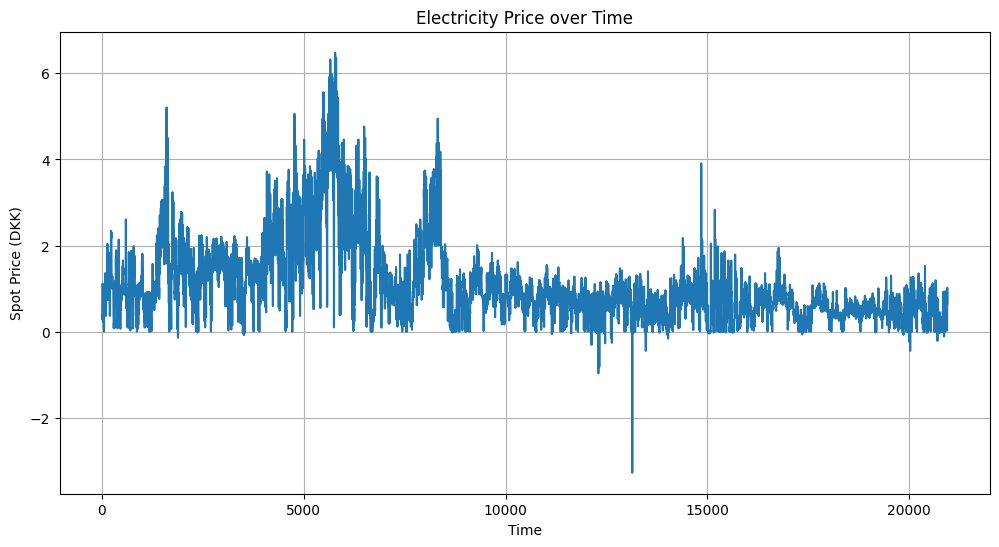

In [24]:
# Plot the time series
plt.figure(figsize=(12, 6))
electricity_df['dk1_spotpricedkk_kwh'].plot()

# Add labels and title
plt.title('Electricity Price over Time')
plt.xlabel('Time')
plt.ylabel('Spot Price (DKK)')
plt.grid(True)

# Show the plot
plt.show()

Histogram with KDE plot providing a comprehensive view of the distribution of electricity prices in the dataset. It highlights the central tendency, spread, skewness, and potential outliers.

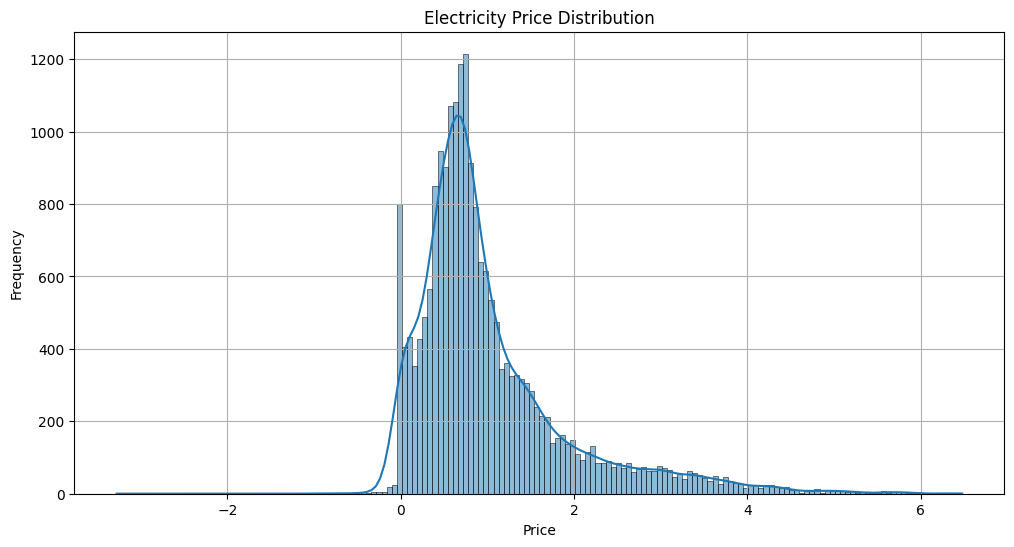

In [25]:
# Data distribution
plt.figure(figsize=(12, 6))
sns.histplot(electricity_df['dk1_spotpricedkk_kwh'], kde=True)

# Add labels and title
plt.title('Electricity Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

### <span style="color:#2656a3;"> ☀️📊 Weather data
Time series line plots for the `historical_weather` dataframe to understanding some of the temporal dynamics of the data.

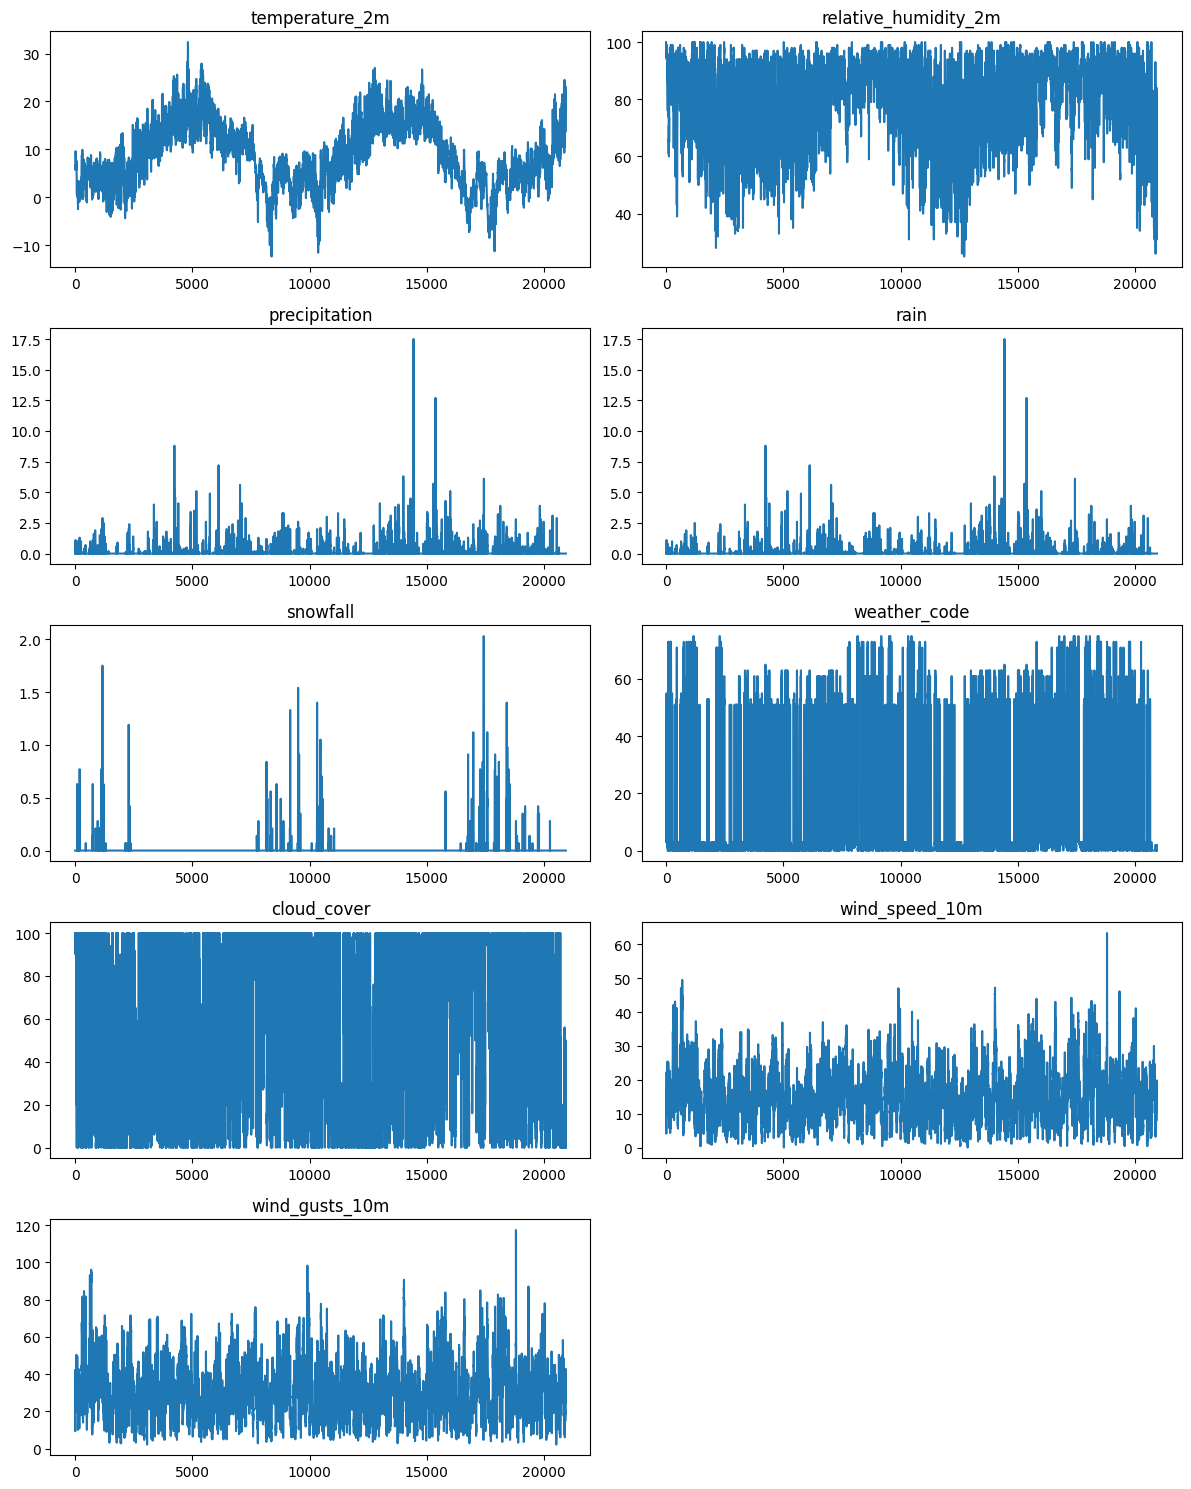

In [26]:
# Load dataset
values = historical_weather_df.values

# Specify columns to plot
groups = [4, 5, 6, 7, 8, 9, 10, 11, 12]

# Calculate the number of rows needed
n_cols = 2
n_rows = (len(groups) + 1) // n_cols

# Plot each column
plt.figure(figsize=(12, n_rows * 3))
for i, group in enumerate(groups):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(values[:, group])
    plt.title(historical_weather_df.columns[group], y=1, loc='center')

# Show the plot
plt.tight_layout()
plt.show()

### <span style="color:#2656a3;"> 📈 Correlation matrix
A correlation matrix helps in understanding the strength and direction of the relationship between different variables in the dataset. This is crucial for identifying which variables might influence each other.

In [27]:
# Drop 'datetime', 'date', and 'timestamp' columns
drop_for_corr = combined_df.drop(columns=['timestamp','date','datetime'])

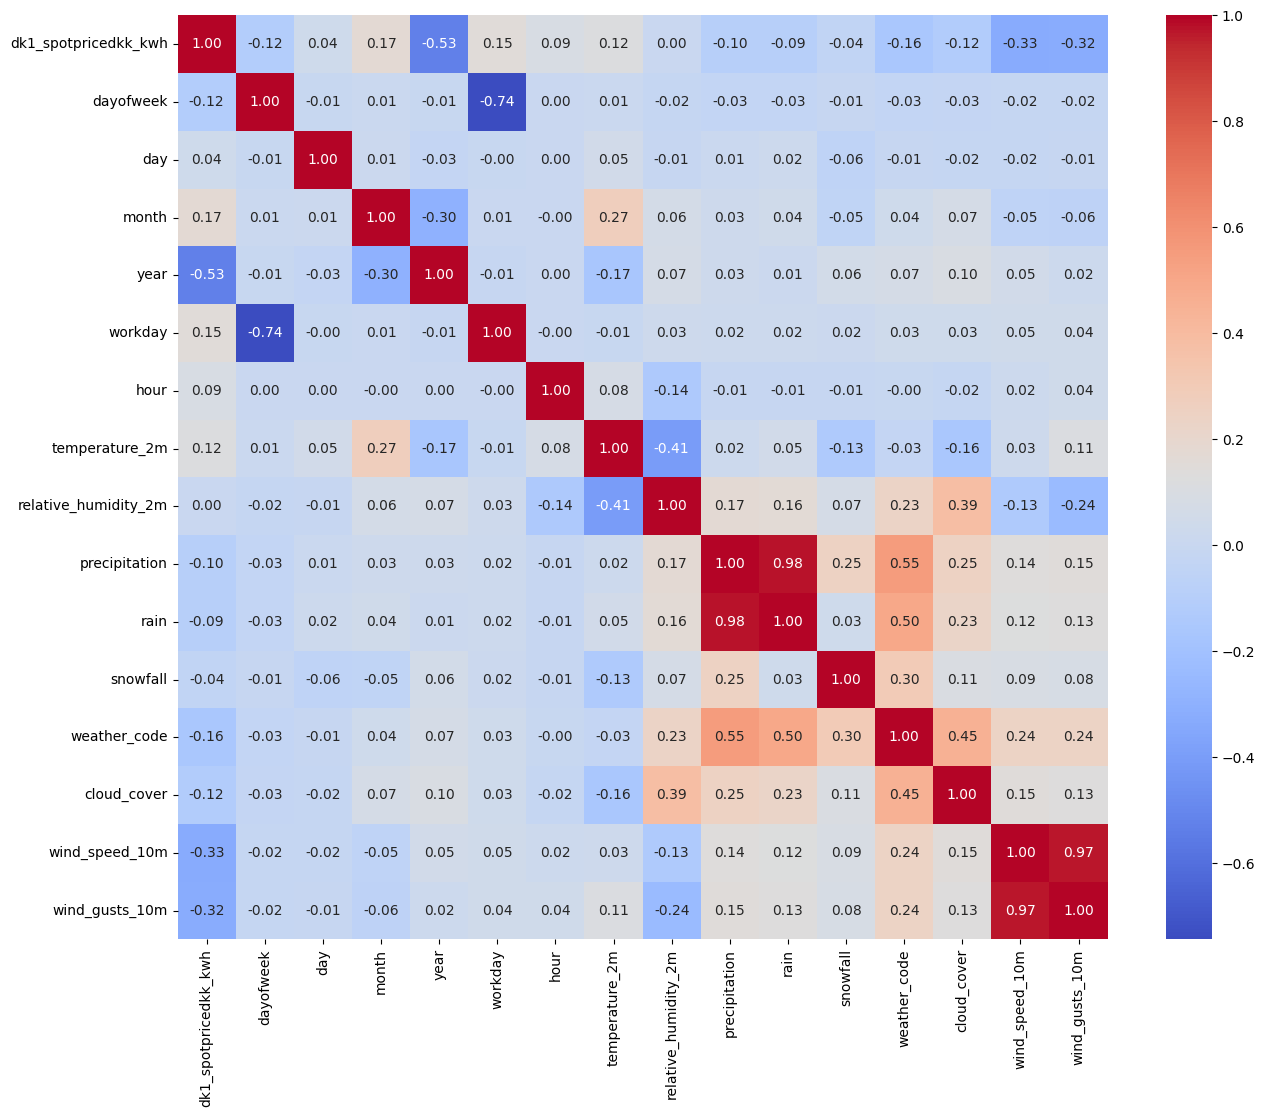

In [28]:
# Create the correlation matrix
correlation_matrix = drop_for_corr.corr()
 
# Set the size of the figure
plt.figure(figsize=(15, 12)) 
 
# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
 
# Display the plot
plt.show()

## <span style="color:#2656a3;"> 🛠️ Feature Engineering </span>

Feature engineering is a crucial step in the data preprocessing pipeline, where we want to creat new informative features or transforming existing ones to enhance model performance. One powerful feature engineering technique for timeseries data involves the use of moving windows, which involves calculating statistical measures over a rolling window of data points.

In [29]:
# Check if there are any missing values in the dataframe
electricity_df[electricity_df['dk1_spotpricedkk_kwh'].isna()]

,timestamp,datetime,date,hour,dk1_spotpricedkk_kwh


In [30]:
# Defining start and end year for the calendar data
start='2022-01-01'
end=datetime.now().date() + timedelta(days=7)

print(f"Fetching historical calendar from {start} to {end}")

Fetching historical calendar from 2022-01-01 to 2024-05-30


In [31]:
# Fetching the Danish calendar from January 1, 2022 to December 31, 2025
# This is dynamic and will update the calendar to the current year plus one year
calendar_hours_df = calendar.calendar_denmark(
    freq='H',
    start=start, 
    end=end
)

In [32]:
# Merging the weather forecast and calendar dataframes
merge_data = pd.merge(electricity_df, calendar_hours_df, how='right', left_on='timestamp', right_on='timestamp')

# Drop columns 'date', 'datetime', and 'timestamp' from the DataFrame 'new_data' to match the training data schema
merge_data = merge_data.drop(columns=['date_x', 'datetime_x', 'hour_x'])
merge_data = merge_data.rename(columns={'date_y': 'date', 'datetime_y': 'datetime', 'hour_y': 'hour'})

# Displaying the last 5 rows of the new data
merge_data.tail()

,timestamp,dk1_spotpricedkk_kwh,datetime,date,hour,dayofweek,day,month,year,workday
21139,1717095600000,NaN,2024-05-30 19:00:00,2024-05-30,19,3,30,5,2024,1
21140,1717099200000,NaN,2024-05-30 20:00:00,2024-05-30,20,3,30,5,2024,1
21141,1717102800000,NaN,2024-05-30 21:00:00,2024-05-30,21,3,30,5,2024,1
21142,1717106400000,NaN,2024-05-30 22:00:00,2024-05-30,22,3,30,5,2024,1
21143,1717110000000,NaN,2024-05-30 23:00:00,2024-05-30,23,3,30,5,2024,1


In [33]:
# Check if there are any missing values in the dataframe
merge_data[merge_data['dk1_spotpricedkk_kwh'].isna()]

,timestamp,dk1_spotpricedkk_kwh,datetime,date,hour,dayofweek,day,month,year,workday
2042,1648346400000,NaN,2022-03-27 02:00:00,2022-03-27,2,6,27,3,2022,0
10778,1679796000000,NaN,2023-03-26 02:00:00,2023-03-26,2,6,26,3,2023,0
19682,1711850400000,NaN,2024-03-31 02:00:00,2024-03-31,2,6,31,3,2024,0
20952,1716422400000,NaN,2024-05-23 00:00:00,2024-05-23,0,3,23,5,2024,1
20953,1716426000000,NaN,2024-05-23 01:00:00,2024-05-23,1,3,23,5,2024,1
...,...,...,...,...,...,...,...,...,...,...
21139,1717095600000,NaN,2024-05-30 19:00:00,2024-05-30,19,3,30,5,2024,1
21140,1717099200000,NaN,2024-05-30 20:00:00,2024-05-30,20,3,30,5,2024,1
21141,1717102800000,NaN,2024-05-30 21:00:00,2024-05-30,21,3,30,5,2024,1
21142,1717106400000,NaN,2024-05-30 22:00:00,2024-05-30,22,3,30,5,2024,1


As we can see in the above there are some missing historical `dk1_spotpricedkk_kwh` when we merge on hour. Here we are just filling in the gab with the `dk1_spotpricedkk_kwh` of the previus hour. But we only want to make the adjustment for historical data. 

In [34]:
# First we make a copy of the merged data for versioning.
merge_data_for_rolling = merge_data.copy()

# Fill NaN values with value from previous row if date is before today
today = datetime.today().date()
mask = merge_data_for_rolling['datetime'].dt.date < today
merge_data_for_rolling.loc[mask, 'dk1_spotpricedkk_kwh'] = merge_data_for_rolling['dk1_spotpricedkk_kwh'].ffill()

In [35]:
# Now we want to check if there are any missing values in the new dataframe
merge_data_for_rolling[merge_data_for_rolling['dk1_spotpricedkk_kwh'].isna()]

,timestamp,dk1_spotpricedkk_kwh,datetime,date,hour,dayofweek,day,month,year,workday
20952,1716422400000,NaN,2024-05-23 00:00:00,2024-05-23,0,3,23,5,2024,1
20953,1716426000000,NaN,2024-05-23 01:00:00,2024-05-23,1,3,23,5,2024,1
20954,1716429600000,NaN,2024-05-23 02:00:00,2024-05-23,2,3,23,5,2024,1
20955,1716433200000,NaN,2024-05-23 03:00:00,2024-05-23,3,3,23,5,2024,1
20956,1716436800000,NaN,2024-05-23 04:00:00,2024-05-23,4,3,23,5,2024,1
...,...,...,...,...,...,...,...,...,...,...
21139,1717095600000,NaN,2024-05-30 19:00:00,2024-05-30,19,3,30,5,2024,1
21140,1717099200000,NaN,2024-05-30 20:00:00,2024-05-30,20,3,30,5,2024,1
21141,1717102800000,NaN,2024-05-30 21:00:00,2024-05-30,21,3,30,5,2024,1
21142,1717106400000,NaN,2024-05-30 22:00:00,2024-05-30,22,3,30,5,2024,1


Now we only have missing `dk1_spotpricedkk_kwh` values for non_historical data.

In [36]:
# Defining a copy of the combined data to avoid modifying the original dataframe
electricity_window_df = merge_data_for_rolling.copy()

# Adding a column with the mean for the previous 1 week
electricity_window_df['prev_1w_mean'] = electricity_window_df['dk1_spotpricedkk_kwh'].rolling(window=24*7, min_periods=1).mean()

# Adding a column with the mean for the previous 2 weeks
electricity_window_df['prev_2w_mean'] = electricity_window_df['dk1_spotpricedkk_kwh'].rolling(window=24*14, min_periods=1).mean()

# Adding a column with the mean for the previous 4 weeks
electricity_window_df['prev_4w_mean'] = electricity_window_df['dk1_spotpricedkk_kwh'].rolling(window=24*28, min_periods=1).mean()

# Only keep the columns 'timestamp', 'prev_1w_mean', 'prev_2w_mean', and 'prev_4w_mean'
electricity_window_df=electricity_window_df[['timestamp', 'prev_1w_mean', 'prev_2w_mean', 'prev_4w_mean']]

# Display the last 120 rows of the DataFrame
electricity_window_df.tail(120)

,timestamp,prev_1w_mean,prev_2w_mean,prev_4w_mean
21024,1716681600000,0.401972,0.269212,0.367549
21025,1716685200000,0.399179,0.268777,0.367588
21026,1716688800000,0.396359,0.268586,0.367709
21027,1716692400000,0.393618,0.268500,0.367932
21028,1716696000000,0.390882,0.268431,0.368204
...,...,...,...,...
21139,1717095600000,NaN,0.348668,0.383060
21140,1717099200000,NaN,0.349709,0.383205
21141,1717102800000,NaN,0.350812,0.383351
21142,1717106400000,NaN,0.352078,0.383561


## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store

We connect to Hopsworks Feature Store so we can access and create feature groups.

In [37]:
# Importing the hopsworks module for interacting with the Hopsworks platform
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#2656a3;"> 🪄 Creating Feature Groups
A feature group can be seen as a collection of conceptually related features. In this case we create feature groups for the 
- eletricity price data,
- weather data,
- calendar data.

We specify a `primary_key` as `date` and `timestamp`, so we are able to join them when we create a dataset for training later in part `3_training_pipeline`.
We define a name and a short describtion of the feature group's contents and a version number. 

`event_time` is specifyed as `timestamp`. If event_time is set the feature group can be used for point-in-time joins.

In [38]:
# Creating the feature group for the electricity prices
electricity_fg = fs.get_or_create_feature_group(
    name="electricity_prices",
    version=1,
    description="Electricity prices from Energidata API",
    primary_key=["date","timestamp"], 
    event_time="timestamp",
)

We have now outlined metadata for the feature group. Data hasn't been stored yet, and there's no schema defined. To store data persistently for the feature group, we populate it with its associated data using the `insert` function.

In [39]:
# Inserting the electricity_df into the feature group named electricity_fg
electricity_fg.insert(electricity_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/550040/fs/545863/fg/843087


Uploading Dataframe: 100.00% |██████████| Rows 20949/20949 | Elapsed Time: 00:08 | Remaining Time: 00:00


Launching job: electricity_prices_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/550040/jobs/named/electricity_prices_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x13d5b6650>, None)

We make a descriptions for each feature we put into the feature group. In this way we are adding more information and documentation to the user.

In [40]:
# List of descriptions for electricity features
electricity_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp of the event time"},
    {"name": "date", "description": "Date of the electricity measurement"},
    {"name": "datetime", "description": "Date and time of the electricity measurement"},
    {"name": "hour", "description": "Hour of the day"},
    {"name": "dk1_spotpricedkk_kwh", "description": "Spot price in DKK per KWH"}, 
]

# Updating feature descriptions
for desc in electricity_feature_descriptions: 
    electricity_fg.update_feature_description(desc["name"], desc["description"])

We replicate the process for both the `electricity_price_window_fg` and `weather_fg` and `danish_holidays_fg` by establishing feature groups and inserting the dataframes into their respective feature groups.

In [41]:
# Creating the feature group for the weather data
electricity_price_window_fg = fs.get_or_create_feature_group(
    name="electricity_price_window",
    version=1,
    description="Moving average of electricity prices",
    primary_key=["timestamp"], 
    event_time="timestamp",
)

In [42]:
# Inserting the electricity_window_df into the feature group named electricity_price_window_fg
electricity_price_window_fg.insert(electricity_window_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/550040/fs/545863/fg/843088


Uploading Dataframe: 100.00% |██████████| Rows 21144/21144 | Elapsed Time: 00:08 | Remaining Time: 00:00


Launching job: electricity_price_window_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/550040/jobs/named/electricity_price_window_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x13d68a050>, None)

In [43]:
# List of descriptions for electricity features
electricity_price_window_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp for the electricity measurement"},
    {"name": "prev_1w_mean", "description": "Avarege electricity price for the previous week"},
    {"name": "prev_2w_mean", "description": "Avarege electricity price for the previous two weeks"},
    {"name": "prev_4w_mean", "description": "Avarege electricity price for the previous four weeks"} 
]

# Updating feature descriptions
for desc in electricity_price_window_feature_descriptions: 
    electricity_price_window_fg.update_feature_description(desc["name"], desc["description"])

In [44]:
# Creating the feature group for the weather data
weather_fg = fs.get_or_create_feature_group(
    name="weather_measurements",
    version=1,
    description="Weather measurements from Open Meteo API",
    primary_key=["date", "timestamp"], 
    event_time="timestamp",
)

In [45]:
# Inserting the weather_df into the feature group named weather_fg
weather_fg.insert(historical_weather_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/550040/fs/545863/fg/843089


Uploading Dataframe: 100.00% |██████████| Rows 20928/20928 | Elapsed Time: 00:09 | Remaining Time: 00:00


Launching job: weather_measurements_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/550040/jobs/named/weather_measurements_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x13d4f50d0>, None)

In [46]:
# List of descriptions for weather features
weather_feature_descriptions = [
    {"name": "timestamp", "description": "Timestamp for the weather measurement"},
    {"name": "date", "description": "Date of the weather measurement"},
    {"name": "datetime", "description": "Date and time of the weather measurement"},
    {"name": "hour", "description": "Hour of the day"},
    {"name": "temperature_2m", "description": "Temperature at 2m above ground"},
    {"name": "relative_humidity_2m", "description": "Relative humidity at 2m above ground"},
    {"name": "precipitation", "description": "Precipitation"},
    {"name": "rain", "description": "Rain"},
    {"name": "snowfall", "description": "Snowfall"},   
    {"name": "weather_code", "description": "Weather code"},   
    {"name": "cloud_cover", "description": "Cloud cover"},   
    {"name": "wind_speed_10m", "description": "Wind speed at 10m above ground"},   
    {"name": "wind_gusts_10m", "description": "Wind gusts at 10m above ground"},   
]

# Updating feature descriptions
for desc in weather_feature_descriptions: 
    weather_fg.update_feature_description(desc["name"], desc["description"])

In [47]:
# Creating the feature group for the danish calendar
danish_calendar_fg = fs.get_or_create_feature_group(
    name="dk_calendar",
    version=1,
    description="Danish calendar",
    primary_key=["date"],
)

In [48]:
# Inserting the calendar_df into the feature group named danish_calendar_fg
danish_calendar_fg.insert(calendar_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/550040/fs/545863/fg/843090


Uploading Dataframe: 100.00% |██████████| Rows 35064/35064 | Elapsed Time: 00:09 | Remaining Time: 00:00


Launching job: dk_calendar_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/550040/jobs/named/dk_calendar_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x137484110>, None)

In [49]:
# List of descriptions for danish_calendar features
danish_calendar_feature_descriptions = [
    {"name": "date", "description": "Date in the calendar"},
    {"name": "day", "description": "Day number of the week. Monday is 0 and Sunday is 6"},
    {"name": "month", "description": "Month number of the year"},
    {"name": "workday", "description": "Workday or not a workday. Workday is 1 and not a workday is 0"},
]

# Updating feature descriptions
for desc in danish_calendar_feature_descriptions: 
    danish_calendar_fg.update_feature_description(desc["name"], desc["description"])

---
## <span style="color:#2656a3;">⏭️ **Next:** Part 02: Feature Pipeline </span>

Next we will generate new data for the Feature Groups.